## Imports

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

## Download the training dataset

We use the DIV2K Dataset, a prominent single-image super-resolution dataset with 1,000
images of scenes with various sorts of degradations,
divided into 800 images for training, 100 images for validation, and 100
images for testing. We use 4x bicubic downsampled images as our "low quality" reference.

In [ ]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.MHGV2O_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.MHGV2O_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


## Flip, crop and resize images

In [ ]:

def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped


## Prepare a `tf.data.Dataset` object

We augment the training data with random horizontal flips and 90 rotations.

As low resolution images, we use 24x24 RGB input patches.

In [ ]:

def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

## Visualize the data

Let's visualize a few sample images:

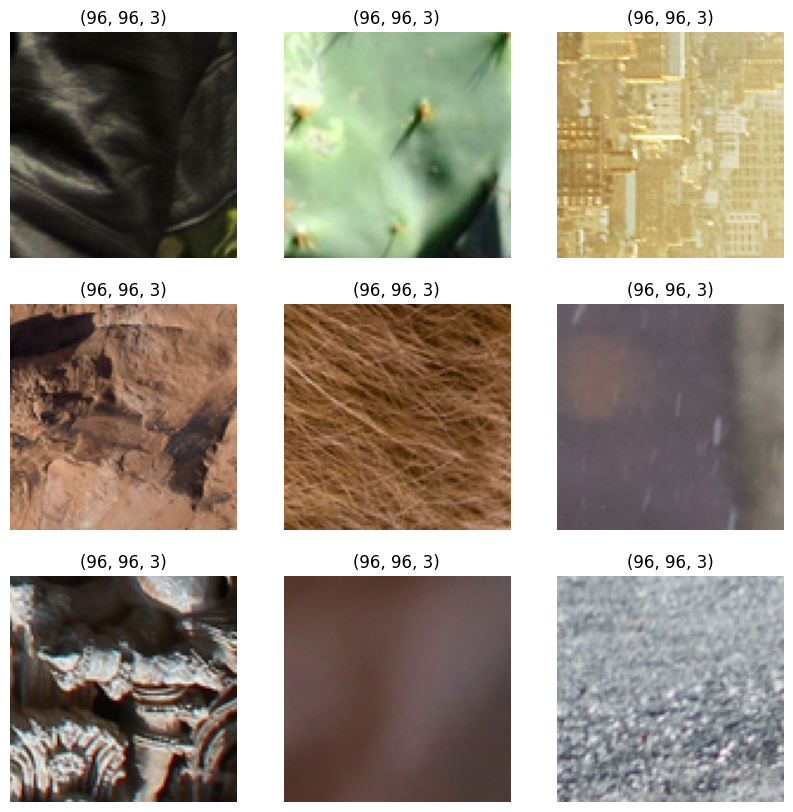

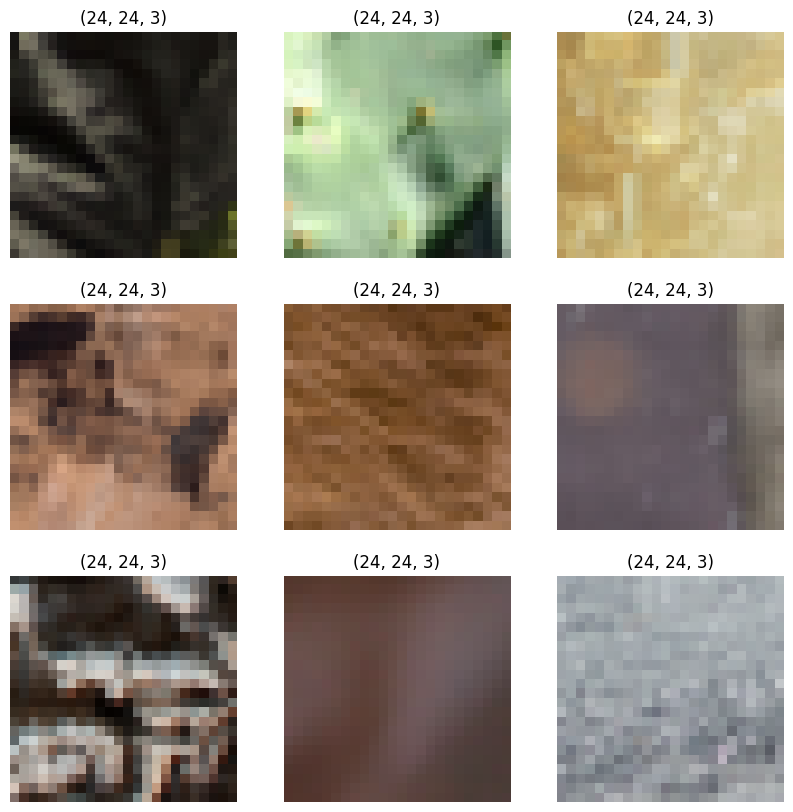

In [ ]:
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value


## Build the model

In the paper, the authors train three models: EDSR, MDSR, and a baseline model. In this code example,
we only train the baseline model.

### Comparison with model with three residual blocks

The residual block design of EDSR differs from that of ResNet. Batch normalization
layers have been removed (together with the final ReLU activation): since batch normalization
layers normalize the features, they hurt output value range flexibility.
It is thus better to remove them. Further, it also helps reduce the
amount of GPU RAM required by the model, since the batch normalization layers consume the same amount of
memory as the preceding convolutional layers.

<img src="https://miro.medium.com/max/1050/1*EPviXGqlGWotVtV2gqVvNg.png" width="500" />

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class DepthToSpace(layers.Layer):
    def __init__(self, block_size, **kwargs):
        super().__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.block_size)

class ResBlock(layers.Layer):
    def __init__(self, num_filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")
        self.conv2 = layers.Conv2D(num_filters, 3, padding="same")
        self.add = layers.Add()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.add([inputs, x])

class UpsamplingBlock(layers.Layer):
    def __init__(self, num_filters, factor=2, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
        self.conv1 = layers.Conv2D(num_filters * (factor ** 2), 3, padding="same")
        self.depth_to_space1 = DepthToSpace(block_size=factor)
        self.conv2 = layers.Conv2D(num_filters * (factor ** 2), 3, padding="same")
        self.depth_to_space2 = DepthToSpace(block_size=factor)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.depth_to_space1(x)
        x = self.conv2(x)
        x = self.depth_to_space2(x)
        return x

class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        super_resolution_img = tf.round(super_resolution_img)
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img

def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))

    # Initial scaling and feature extraction
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # Residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(num_filters)(x_new)

    # Global residual connection
    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    # Upsampling
    x = UpsamplingBlock(num_filters)(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    # Final scaling
    output_layer = layers.Rescaling(scale=255)(x)

    return EDSRModel(input_layer, output_layer)

# Create the model
model = make_model(num_filters=64, num_of_residual_blocks=16)

## Train the model

In [ ]:
# Using adagrad optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adagrad (
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:617: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 389ms/step - psnr: 6.7417 - loss: 93.9893 - val_loss: 33.8148 - val_psnr: 5.6451
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - psnr: 8.0466 - loss: 106.2212 - val_loss: 26.3013 - val_psnr: 7.1995
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 8.3329 - loss: 104.6322 - val_loss: 23.8336 - val_psnr: 7.5270
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - psnr: 7.9714 - loss: 106.1107 - val_loss: 20.8720 - val_psnr: 8.1518
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - psnr: 8.0768 - loss: 107.2743 - val_loss: 20.6551 - val_psnr: 10.7396
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 8.2950 - loss: 109.7976 - val_loss: 20.1782 - val_psnr: 7.0414
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - psnr: 7.7872 - loss: 107.0095 - val_loss: 17.4283 - val_psnr: 9.2441
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - psnr: 8.2688 - loss: 108.1475 - val_loss: 15.4130 - val_psnr: 6.7768
Epoch 9/1

## Run inference on new images and plot the results

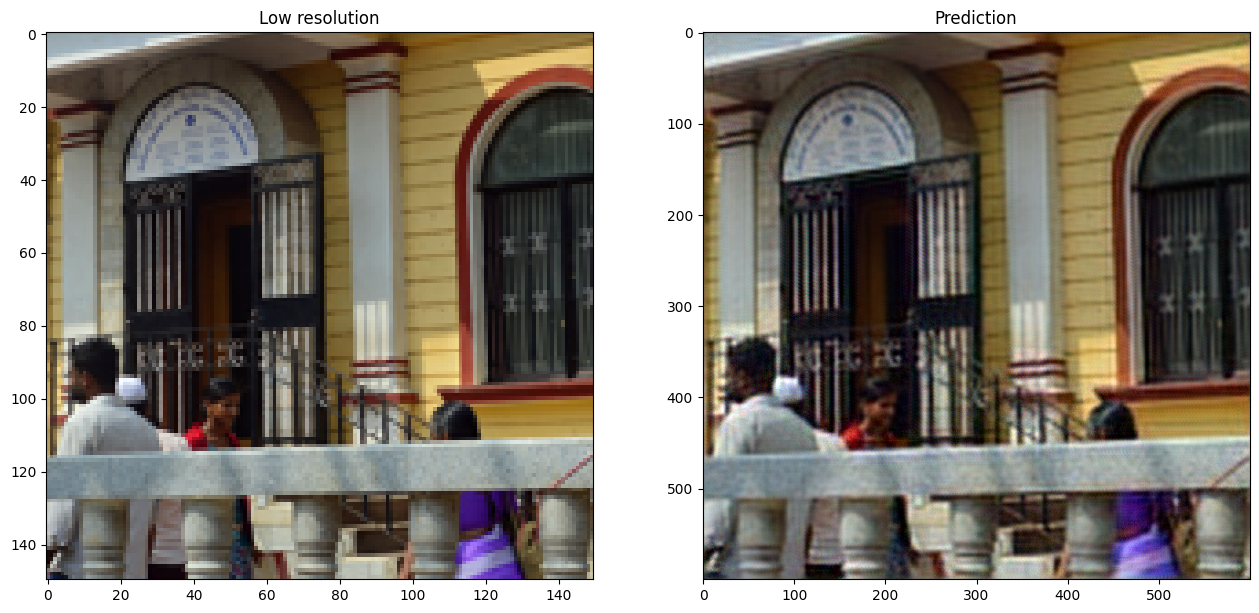

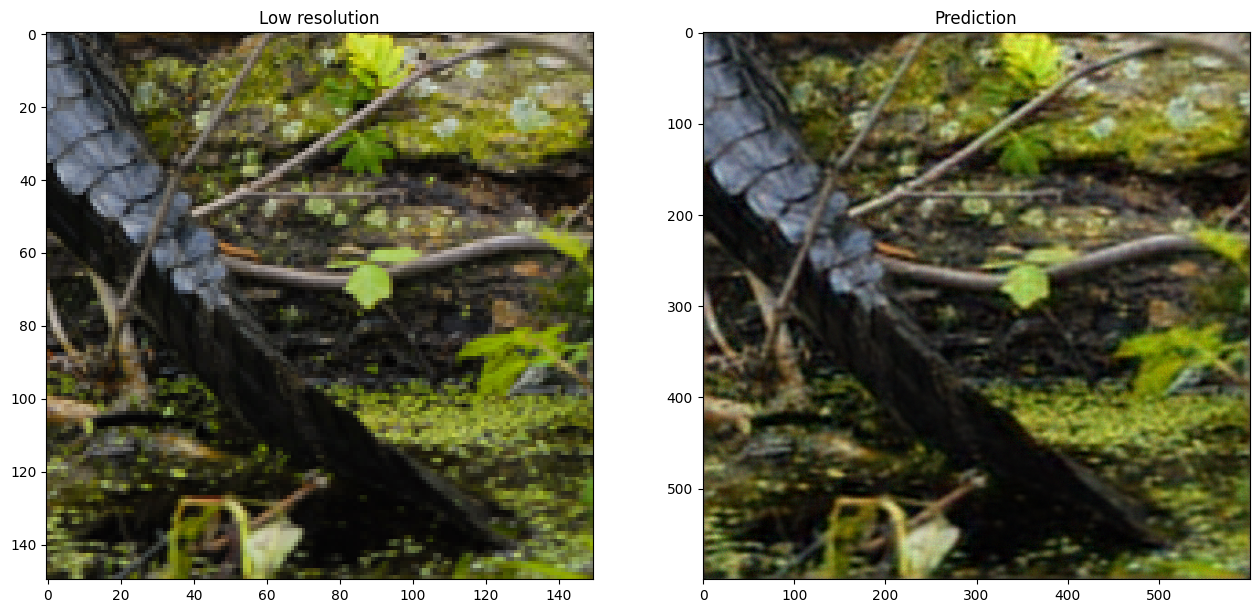

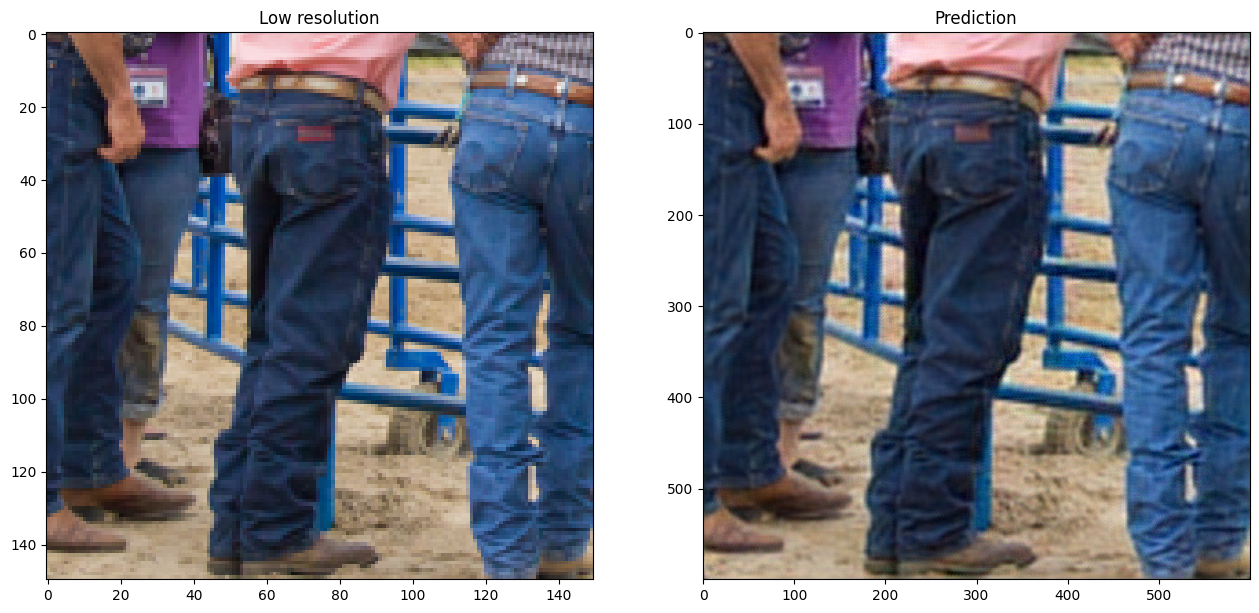

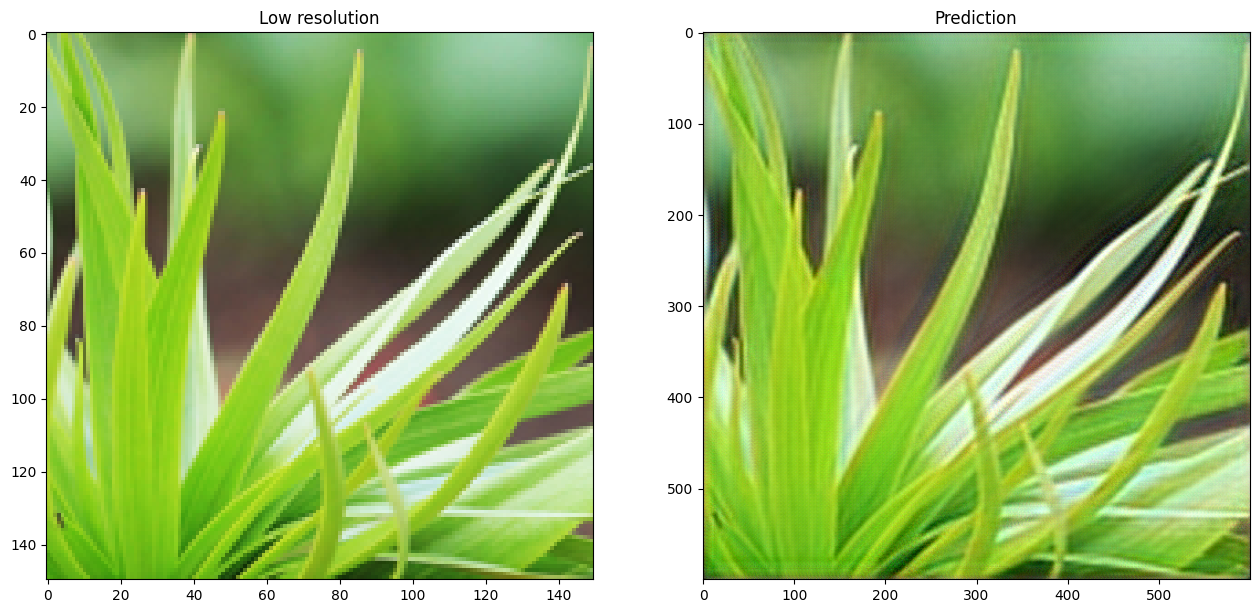

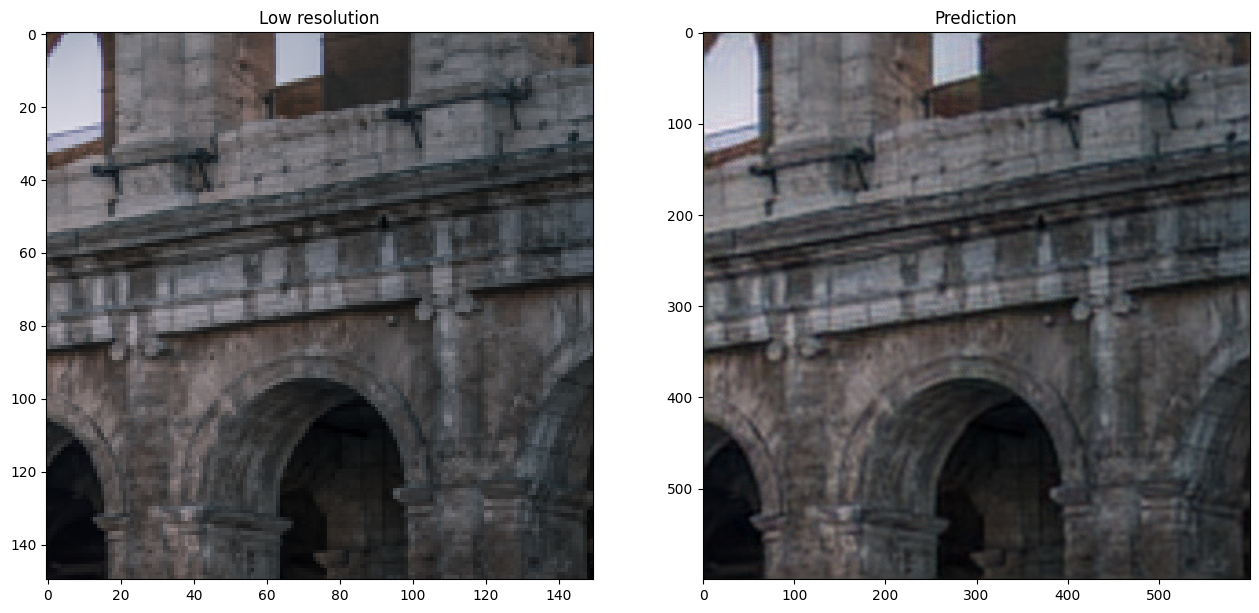

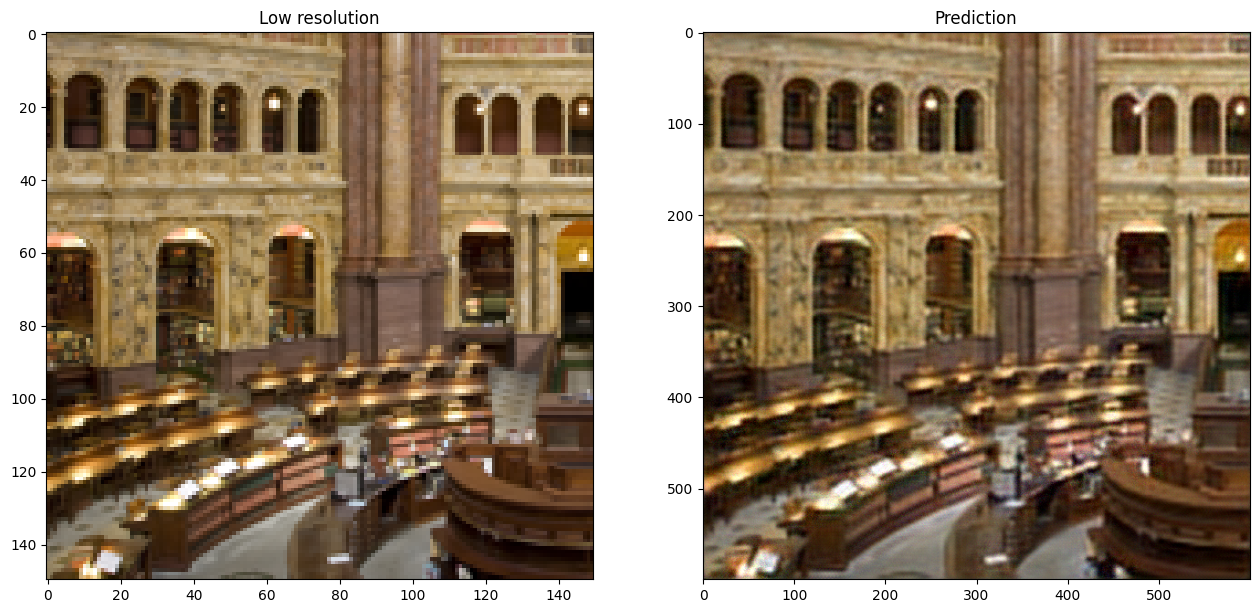

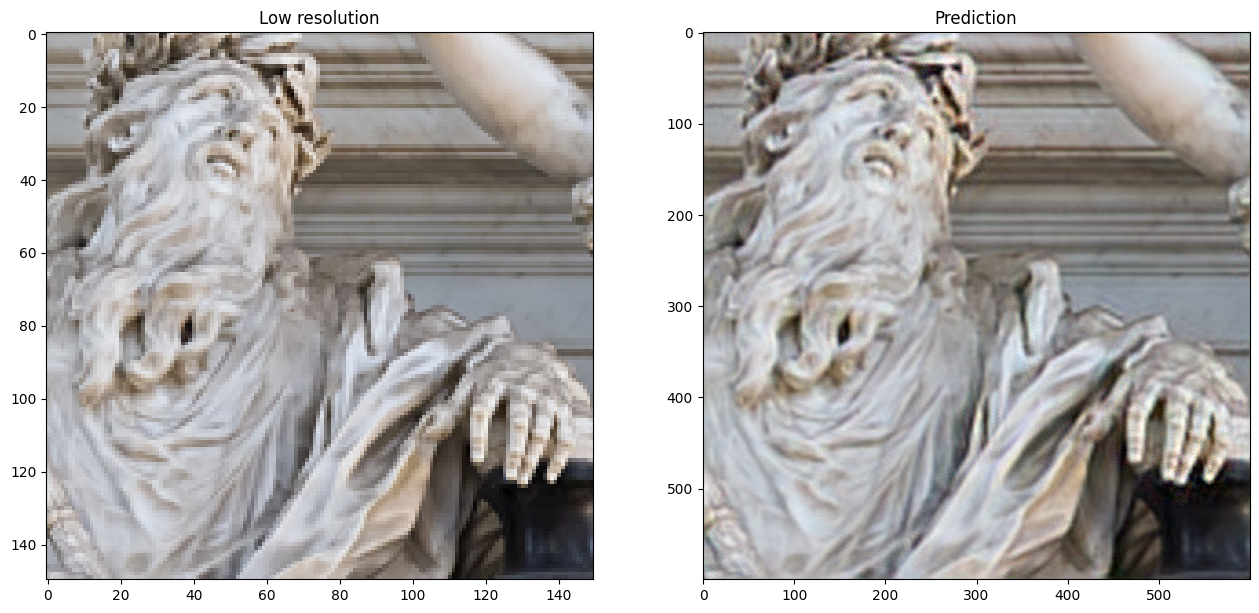

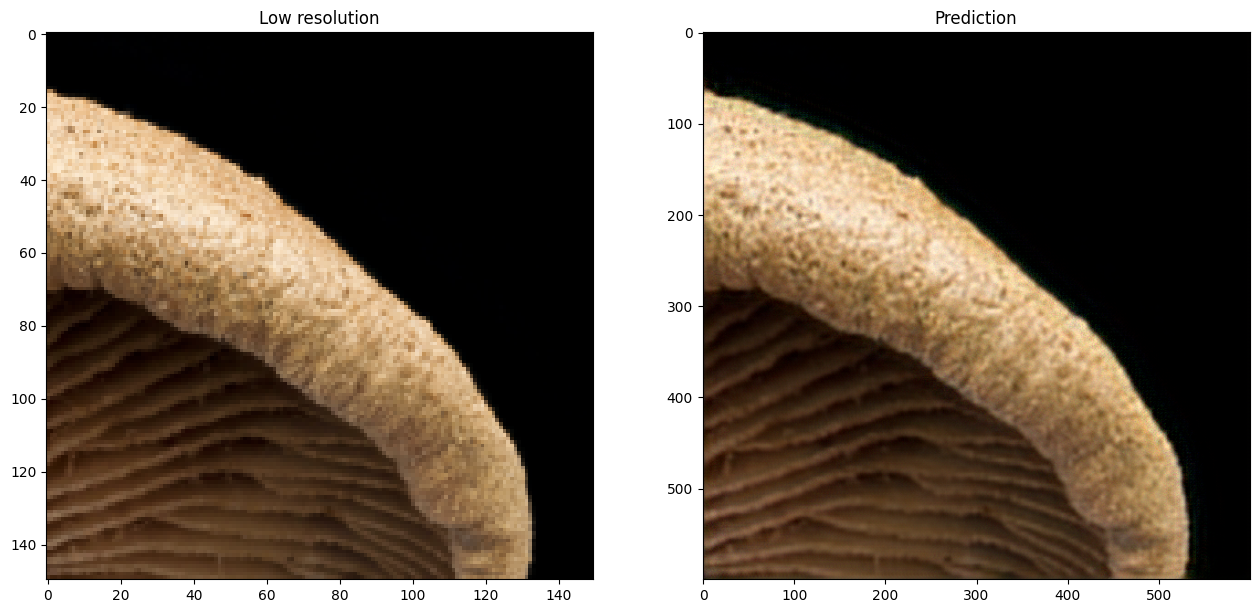

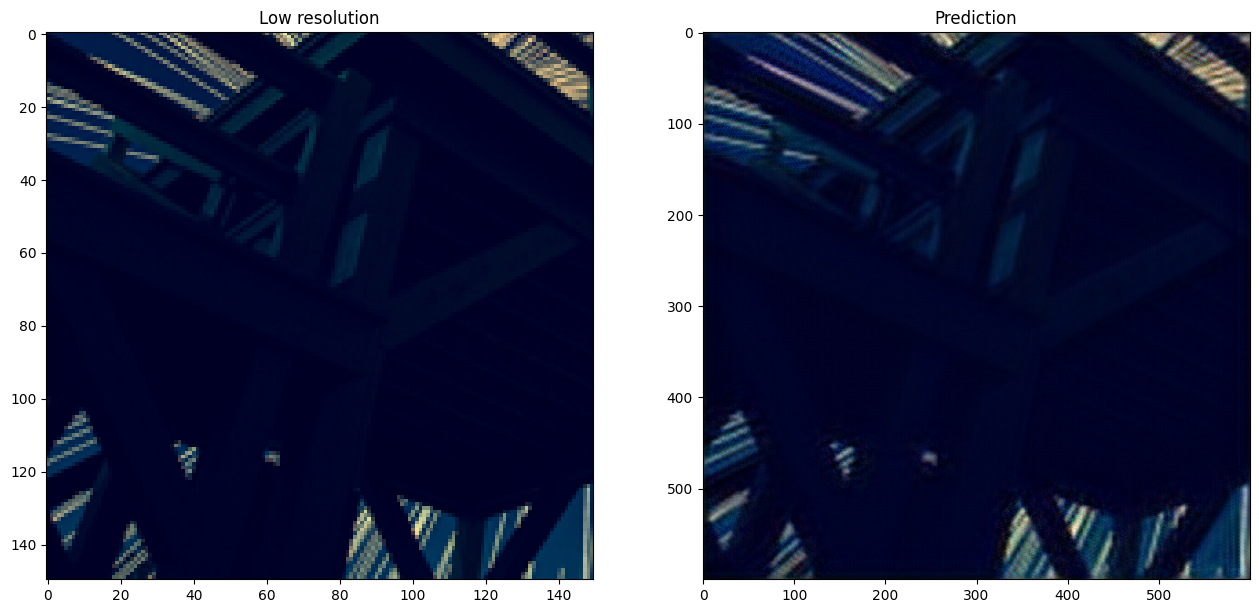

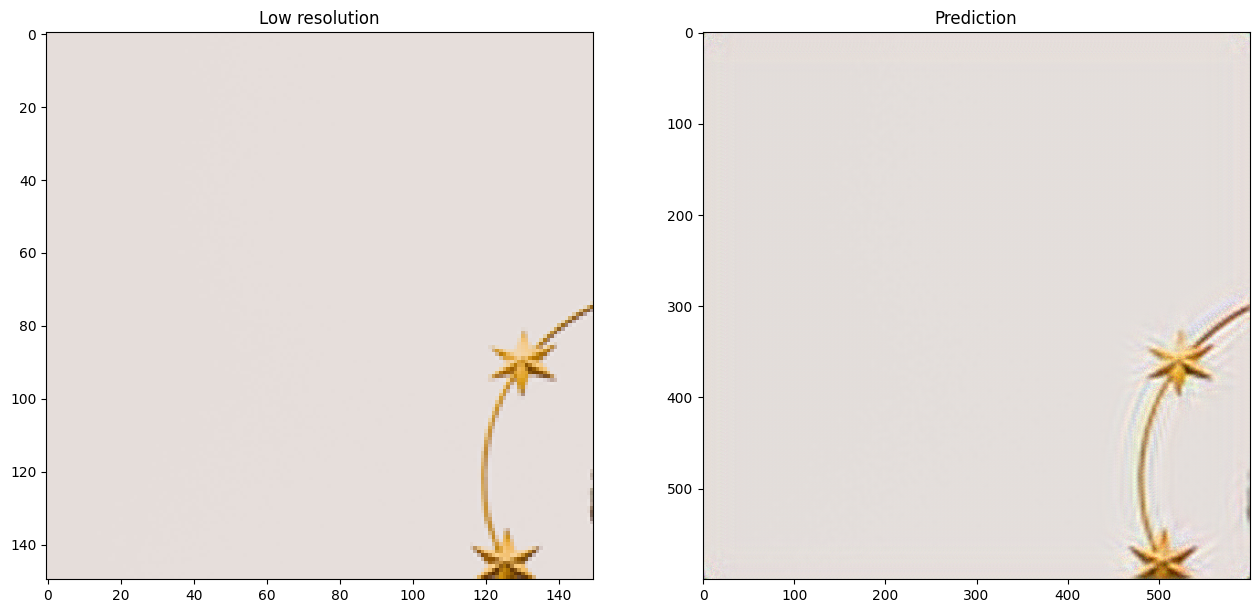

In [ ]:

def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)

## Final remarks

In this example, we implemented the EDSR model (Enhanced Deep Residual Networks for Single Image
Super-Resolution). You could improve the model accuracy by training the model for more epochs, as well as
training the model with a wider variety of inputs with mixed downgrading factors, so as to
be able to handle a greater range of real-world images.

You could also improve on the given baseline EDSR model by implementing EDSR+,
or MDSR( Multi-Scale super-resolution) and MDSR+,
which were proposed in the same paper.

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-EDSR-red.svg)](https://huggingface.co/keras-io/EDSR) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-EDSR-red.svg)](https://huggingface.co/spaces/keras-io/EDSR) |